<center><h1>Modelling</h1></center> <br>
The purpose of this notebook is to utilize the merged seasons data from <a href='https://github.com/vaastav/Fantasy-Premier-League/'>vaastav's public github repository</a> which regularly accesses and updates from the FPL API storing the data in csv files.

We will begin with a shorter exploratory analysis and begin modelling based on features of influence, creativity and threat.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

cleaned_seasons = pd.read_csv('../data/cleaned_merged_seasons.csv', index_col=0)
cleaned_seasons.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98402 entries, 0 to 98401
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           98402 non-null  object 
 1   name               98402 non-null  object 
 2   position           98402 non-null  object 
 3   team_x             48930 non-null  object 
 4   assists            98402 non-null  int64  
 5   bonus              98402 non-null  int64  
 6   bps                98402 non-null  int64  
 7   clean_sheets       98402 non-null  int64  
 8   creativity         98402 non-null  float64
 9   element            98402 non-null  int64  
 10  fixture            98402 non-null  int64  
 11  goals_conceded     98402 non-null  int64  
 12  goals_scored       98402 non-null  int64  
 13  ict_index          98402 non-null  float64
 14  influence          98402 non-null  float64
 15  kickoff_time       98402 non-null  object 
 16  minutes            984

C:\Users\Farhan Kassam\AppData\Local\Temp\ipykernel_10292\1541133532.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_seasons = pd.read_csv('../data/cleaned_merged_seasons.csv', index_col=0)


In [2]:
cleaned_seasons.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2016-08-15T19:00:00Z,0,4,Chelsea,0,0,0,0,1,0,14023,1.0,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,3,0,0,0.9,8.2,2016-08-13T14:00:00Z,15,17,Spurs,0,0,0,0,1,0,13918,1.0,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,8,3,0,3.0,2.2,2016-08-14T15:00:00Z,60,9,Liverpool,0,0,0,0,1,0,163170,4.0,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,7,0,0,0.0,0.0,2016-08-13T14:00:00Z,0,13,Southampton,0,0,0,0,1,0,1051,1.0,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,6,1,0,0.3,2.0,2016-08-13T14:00:00Z,69,14,Stoke,0,0,0,0,1,0,2723,1.0,1.0,0.0,1,0,0,0,45,True,1,1


In [3]:
# Checking if the empty team name values are from seasons 2016-17 to 2019-20

cleaned_seasons.loc[cleaned_seasons['team_x'].isnull() == True,].equals\
(cleaned_seasons.loc[cleaned_seasons['season_x'] <= '2019-20',])

True

Since I've decided not to include the team of a player as a contributing factor to their FPL score I will not be attempting to fill the null values and continue to reduce the shape of the dataframe for relevant columns. 

Although the team name is significant when picking a team since there cannot be more than 3 players from the same team on a Fantasy team, this is only significant in our testing sets which we will pick from the 22/23 season data.

In [4]:
season_slice = cleaned_seasons[['season_x', 'name', 'position', 'GW', 'value', 'minutes', 'influence', 'creativity', 'threat', 'total_points']]
season_slice.head()

,season_x,name,position,GW,value,minutes,influence,creativity,threat,total_points
0,2016-17,Aaron Cresswell,DEF,1,55,0,0.0,0.0,0.0,0
1,2016-17,Aaron Lennon,MID,1,60,15,8.2,0.3,0.0,1
2,2016-17,Aaron Ramsey,MID,1,80,60,2.2,4.9,23.0,2
3,2016-17,Abdoulaye Doucouré,MID,1,50,0,0.0,0.0,0.0,0
4,2016-17,Adam Forshaw,MID,1,45,69,2.0,1.3,0.0,1


In [5]:
last_season = pd.read_csv('../data/merged_gw.csv')
last_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26505 entries, 0 to 26504
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        26505 non-null  object 
 1   position                    26505 non-null  object 
 2   team                        26505 non-null  object 
 3   xP                          26505 non-null  float64
 4   assists                     26505 non-null  int64  
 5   bonus                       26505 non-null  int64  
 6   bps                         26505 non-null  int64  
 7   clean_sheets                26505 non-null  int64  
 8   creativity                  26505 non-null  float64
 9   element                     26505 non-null  int64  
 10  expected_assists            26505 non-null  float64
 11  expected_goal_involvements  26505 non-null  float64
 12  expected_goals              26505 non-null  float64
 13  expected_goals_conceded     265

In [6]:
last_season['season_x'] = '2022-23'

In [7]:
subset_last_season = last_season[['season_x', 'name', 'position', 'GW', 'value', 'minutes', 'influence', 'creativity', 'threat', 'total_points']]
subset_last_season.head()

,season_x,name,position,GW,value,minutes,influence,creativity,threat,total_points
0,2022-23,Nathan Redmond,MID,1,55,1,0.0,0.0,0.0,1
1,2022-23,Junior Stanislas,MID,1,50,1,0.0,0.0,0.0,1
2,2022-23,Armando Broja,FWD,1,55,15,5.2,0.3,19.0,1
3,2022-23,Fabian Schär,DEF,1,45,90,66.0,14.6,25.0,15
4,2022-23,Jonny Evans,DEF,1,45,90,14.0,1.3,0.0,1


In [8]:
all_season = pd.concat([season_slice, subset_last_season], ignore_index=True)
all_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124907 entries, 0 to 124906
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   season_x      124907 non-null  object 
 1   name          124907 non-null  object 
 2   position      124907 non-null  object 
 3   GW            124907 non-null  int64  
 4   value         124907 non-null  int64  
 5   minutes       124907 non-null  int64  
 6   influence     124907 non-null  float64
 7   creativity    124907 non-null  float64
 8   threat        124907 non-null  float64
 9   total_points  124907 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 9.5+ MB


Now we have data from 2016-17 to 2022-23 in our dataframe. Since the ict statistics are populated on a per game basis, we will create a lagged feature for all of our attributes for the previous match, previous 3 matches and previous 5 matches averages.

In [9]:
all_season.columns[5:9]

Index(['minutes', 'influence', 'creativity', 'threat'], dtype='object')

In [10]:
to_lag = all_season.columns[5:9]

for col in to_lag:
    for lag in [1,3,5]:
        lagged = 'last_' + str(lag)+ '_' + col
        all_season[lagged] = all_season.sort_values('GW').groupby(['name', 'season_x'], group_keys=False)[col].apply(lambda x: (x.rolling(min_periods=1, window=lag+1).sum() - x)/lag)

In [11]:
all_season.head()

,season_x,name,position,GW,value,minutes,influence,creativity,threat,total_points,last_1_minutes,last_3_minutes,last_5_minutes,last_1_influence,last_3_influence,last_5_influence,last_1_creativity,last_3_creativity,last_5_creativity,last_1_threat,last_3_threat,last_5_threat
0,2016-17,Aaron Cresswell,DEF,1,55,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-17,Aaron Lennon,MID,1,60,15,8.2,0.3,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-17,Aaron Ramsey,MID,1,80,60,2.2,4.9,23.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-17,Abdoulaye Doucouré,MID,1,50,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-17,Adam Forshaw,MID,1,45,69,2.0,1.3,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since the largest lag is previous 5 matches, the first 5 gameweeks of each season are essentially unknown values for these variables. Therefore we can drop all of these datapoints.

In [12]:
len(all_season.loc[all_season['GW'] <=5, ]) / len(all_season)

0.11633455290736308

In [13]:
len(all_season.loc[all_season['total_points'] == 0,]) / len(all_season)

0.5370635753000232

In [14]:
(all_season.loc[all_season['GW'] <=5, 'total_points']).eq(all_season.loc[all_season['total_points'] == 0, 'total_points']).sum() / len(all_season)

0.05623383797545374

Therefore we are losing about 12% of the data due to the lagged variables and 54% of the data from players who did not earn any points due to being benched, injured, receiving negative points etc. There is an approximate of 6% overlap between the lagged variables and players who did not earn points.

At this stage I am opting to <b>remove</b> the data from <b>the first 5 GWs</b> and <b>keep</b> the data from players who did <b>not earn</b> any points.

In [15]:
all_season_lagged = all_season.loc[(all_season['GW'] > 5)].sort_values(['season_x','GW']).reset_index(drop=True)

In [16]:
all_season_lagged = all_season_lagged.drop(to_lag, axis=1)
all_season_lagged.head()

,season_x,name,position,GW,value,total_points,last_1_minutes,last_3_minutes,last_5_minutes,last_1_influence,last_3_influence,last_5_influence,last_1_creativity,last_3_creativity,last_5_creativity,last_1_threat,last_3_threat,last_5_threat
0,2016-17,Aaron Cresswell,DEF,6,54,0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0
1,2016-17,Aaron Lennon,MID,6,57,0,0.0,0.000000,3.0,0.0,0.000000,1.64,0.0,0.0,0.06,0.0,0.000000,0.0
2,2016-17,Aaron Ramsey,MID,6,77,0,0.0,0.000000,12.0,0.0,0.000000,0.44,0.0,0.0,0.98,0.0,0.000000,4.6
3,2016-17,Abdoulaye Doucouré,MID,6,48,0,0.0,0.000000,1.4,0.0,0.000000,0.24,0.0,0.0,0.02,0.0,0.000000,0.0
4,2016-17,Adama Traoré,MID,6,49,0,0.0,3.333333,2.0,0.0,1.333333,0.80,0.0,0.0,0.00,0.0,1.333333,0.8


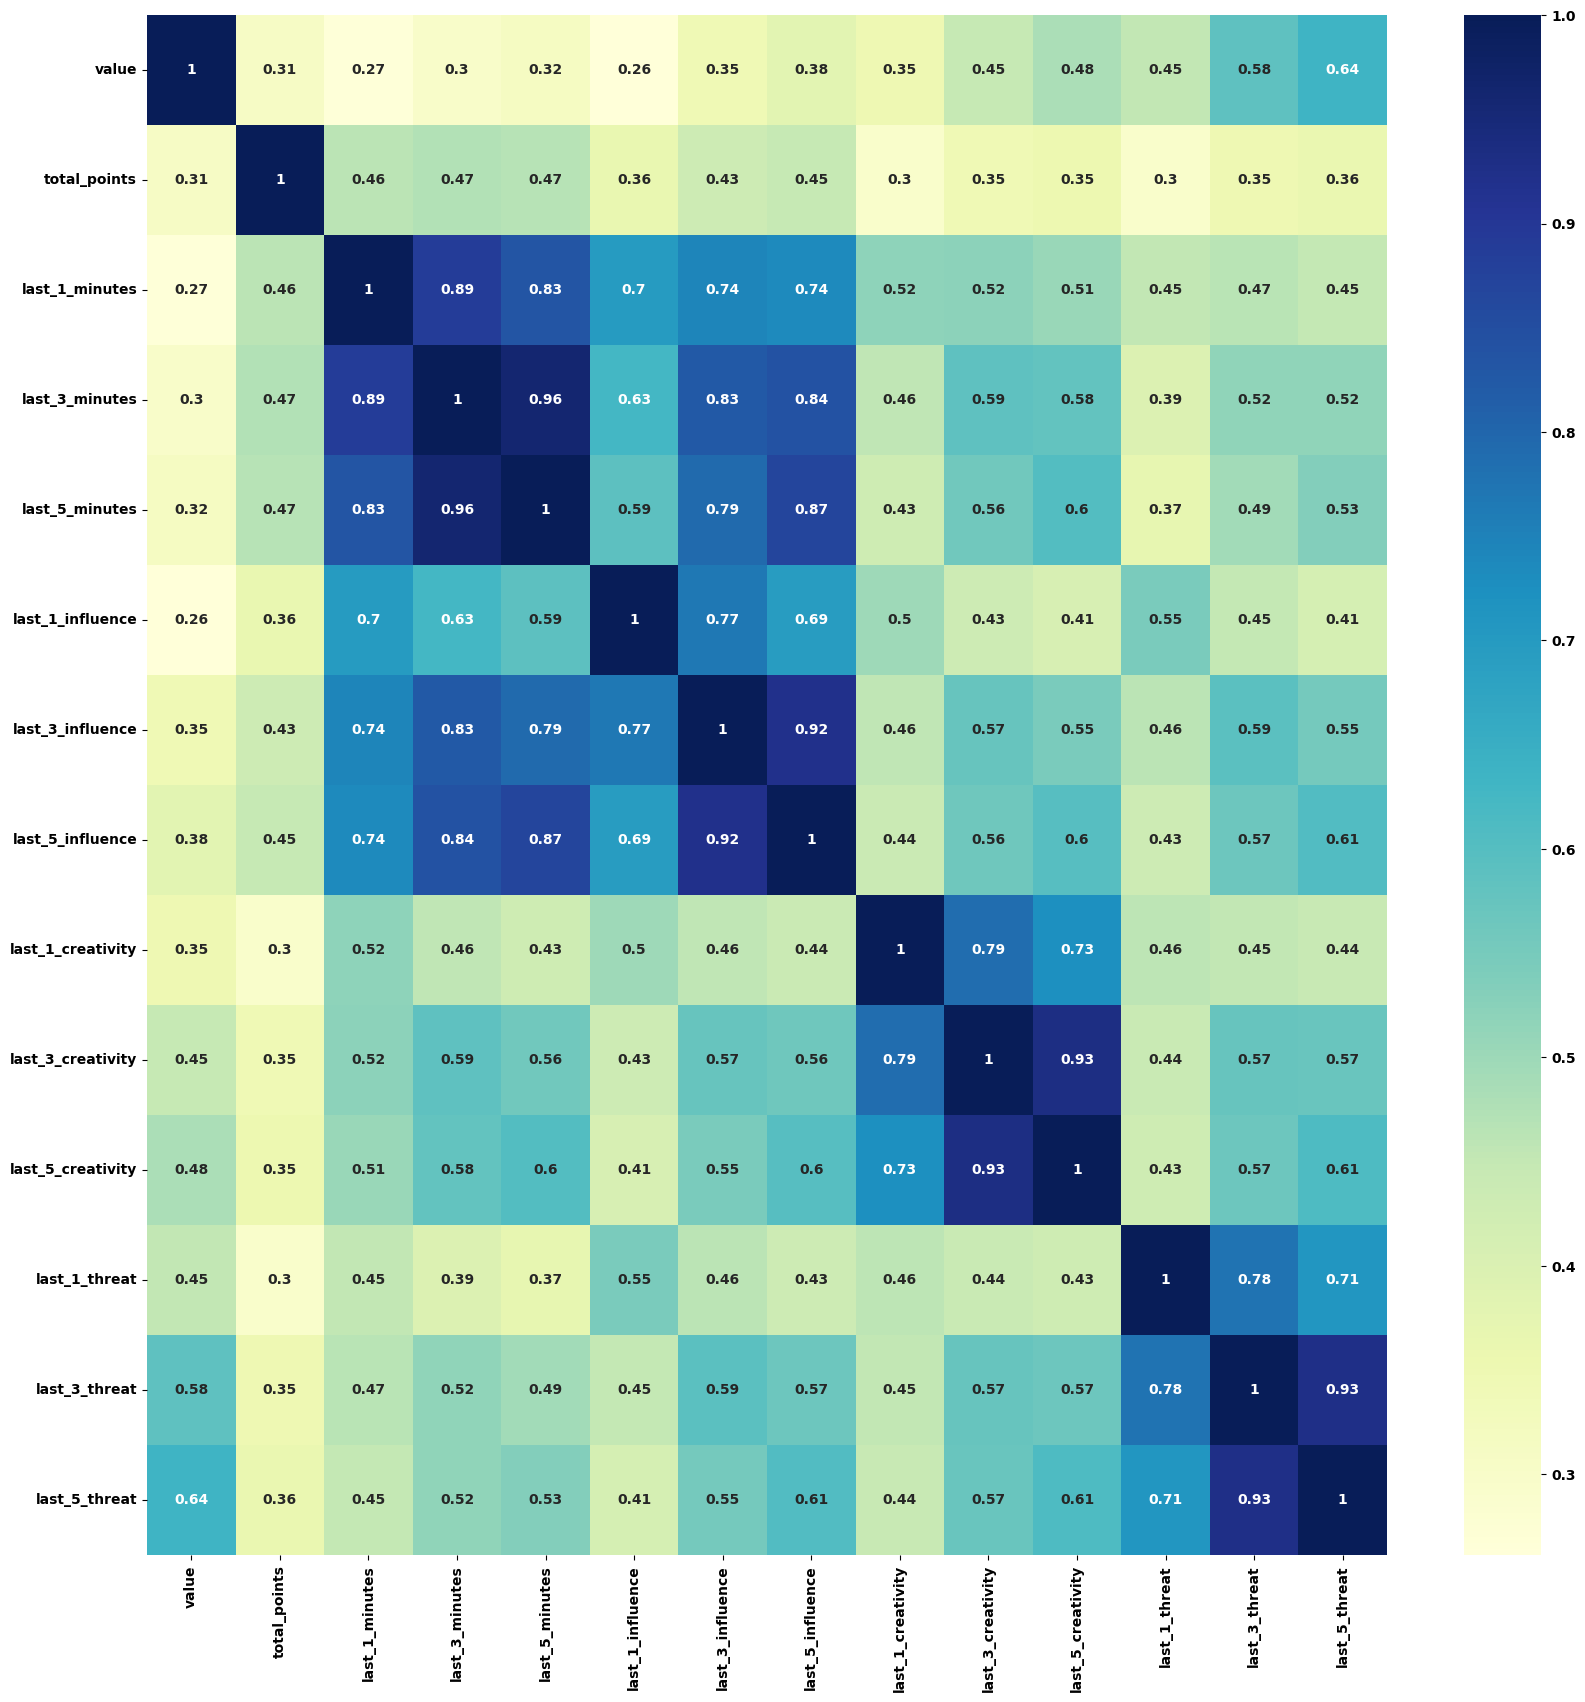

In [17]:
corr = all_season_lagged.iloc[:,4:].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

It seems that the value of a player and change in cost follows their goal_scoring threat from the previous 5 matches with a strong correlation of 0.64. Additionally, it seems that ict statistics in the previous 5 matches have a strong correlation with total_points with influence in last five having a correlation of 0.45, creativity with 0.35 and threat with 0.36.

We can also see the rotation bias with the high collinearity between minutes in previous match, previous 3 matches and previous 5 matches.

Additionally, the strong correlations in ict_statistics between the lagged window may introduce multicollinearity between the variables while also helping us to determine a consistent run of form.

## Train-Test Split/Model Preparation

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

# Fit the OneHotEncoder to the positions column and transform
pos = pd.DataFrame(all_season_lagged['position'])
encoded = ohe.fit_transform(pos)

# Put into a dataframe to get column names
encoded_df = pd.DataFrame(encoded, columns=['DEF', 'FWD', 'GK', 'MID'], dtype=int)

# Add original back in
model_df = pd.concat([all_season_lagged, encoded_df], axis=1)

# Drop position and GK column
model_df = model_df.drop(['position', 'GK'], axis=1)

# Show
model_df.head()

,season_x,name,GW,value,total_points,last_1_minutes,last_3_minutes,last_5_minutes,last_1_influence,last_3_influence,last_5_influence,last_1_creativity,last_3_creativity,last_5_creativity,last_1_threat,last_3_threat,last_5_threat,DEF,FWD,MID
0,2016-17,Aaron Cresswell,6,54,0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,1,0,0
1,2016-17,Aaron Lennon,6,57,0,0.0,0.000000,3.0,0.0,0.000000,1.64,0.0,0.0,0.06,0.0,0.000000,0.0,0,0,1
2,2016-17,Aaron Ramsey,6,77,0,0.0,0.000000,12.0,0.0,0.000000,0.44,0.0,0.0,0.98,0.0,0.000000,4.6,0,0,1
3,2016-17,Abdoulaye Doucouré,6,48,0,0.0,0.000000,1.4,0.0,0.000000,0.24,0.0,0.0,0.02,0.0,0.000000,0.0,0,0,1
4,2016-17,Adama Traoré,6,49,0,0.0,3.333333,2.0,0.0,1.333333,0.80,0.0,0.0,0.00,0.0,1.333333,0.8,0,0,1


In [19]:
# Train test split

X = model_df.drop('total_points', axis = 1)
y = model_df['total_points']

# splitting based on season 
X_train, X_test = X.loc[X['season_x'] <= '2021-22',], X.loc[X['season_x'] > '2021-22',]
y_train, y_test = y[:X_train.shape[0]], y[X_train.shape[0]:]

X_train = X_train.drop(['season_x', 'name', 'GW'], axis = 1)
X_test = X_test.drop(['season_x', 'name', 'GW'], axis = 1)

# Sanity check to make sure shapes of train and test sets are consistent
print(f"X_train Shape: {X_train.shape}\ny_train Shape:{y_train.shape}\n\nX_test Shape:{X_test.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (86826, 16)
y_train Shape:(86826,)

X_test Shape:(23550, 16)
y_test Shape:(23550,)


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from tempfile import mkdtemp
from sklearn import metrics

# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
tsc = TimeSeriesSplit(n_splits = 5)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearRegression())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [LinearRegression()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
#              'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
            }
]

# Cross Validation
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)

In [21]:
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmp6hxq5p7c',
         steps=[('normalise', StandardScaler()), ('model', LinearRegression())])

We will store the best model parameters in a list and then compare the different models against each other with their respective cross validation scores.

In [22]:
models = []
models.append(('LinReg', 'StandardScaler', LinearRegression()))

Let's try to fit another model and see if we can improve the RMSE from the CV tests.

In [23]:
# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
tsc = TimeSeriesSplit(n_splits = 5)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearRegression())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [Lasso()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
              'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
            }
]

# Cross Validation
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)

In [24]:
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpkkn99a4u',
         steps=[('normalise', StandardScaler()), ('model', Lasso(alpha=0.01))])

In [25]:
models.append(('Lasso', 'StandardScaler', Lasso(alpha=0.01)))

In [26]:
fittedgrid.best_score_

-2.2107579457353017

In [27]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Functions to get cross val scores and compare models

def get_cv_scores(models, X, y, k=tsc, seed=999):
    
    names = []
    results = []
    print("Cross val scores:")
    
    for name, scaler, m in models:
        if scaler == None:
            continue
        elif scaler == 'StandardScaler':
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
        elif scaler == 'MinMax':
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X)
        cv_results = -cross_val_score(m, X, y, cv=k, scoring='neg_root_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std() ))
        print("")
        print("*"*88)
        print("")
        
    return names, results

def compare_model_scores(model_names, model_results):
    
    fig = plt.figure()
    fig.suptitle('Model comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names)
    plt.show()

In [28]:
from sklearn.linear_model import Ridge

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', Ridge())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [Ridge()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__alpha': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
            }
]

# Cross Validation based on Time Series Split by number of GWs
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)

In [29]:
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpqmvd1f5o',
         steps=[('normalise', MinMaxScaler()), ('model', Ridge(alpha=50))])

In [30]:
models.append(('Ridge', 'MinMax', Ridge(alpha=50)))

Cross val scores:
LinReg: 2.211314 (0.178856)

****************************************************************************************

Lasso: 2.210765 (0.178241)

****************************************************************************************

Ridge: 2.210427 (0.178299)

****************************************************************************************



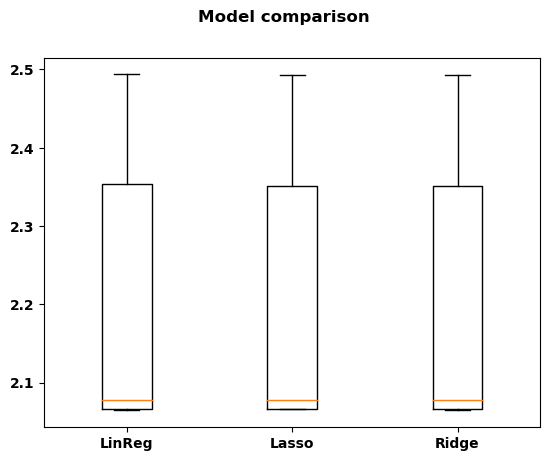

In [31]:
model_names, model_results = get_cv_scores(models, X_train, y_train)
compare_model_scores(model_names, model_results)

As we can see all linear regression models gave around the same RMSE score of 2.21 with their respective hyperparameter tuning. We will attempt to fit 2 more different models before proceeding to change variables and possibly gain a better result.

In [65]:
# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', RandomForestRegressor())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [RandomForestRegressor()], 
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__n_estimators': [i for i in range(25, 100, 25)],
             'model__max_depth': [i for i in range(2, 10, 2)],
             }
]

# Cross Validation based on Time Series Split by number of GWs
grid = RandomizedSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')
fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmp4ljh2jgy',
         steps=[('normalise', None),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=25))])

In [67]:
models.append(('RandomForest', 'None', RandomForestRegressor(max_depth=6, n_estimators=25)))

In [62]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', XGBRegressor())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [XGBRegressor()], 
             'normalise': [MinMaxScaler()],
             'model__max_depth': list(range(3,7)),
             'model__min_child_weight': list(range(10,51)),
             'model__learning_rate':  [0.03, 0.15, 0.3, 0.45, 0.6],
             'model__subsample': [0.8, 0.9, 1.0],
             'model__colsample_bytree': [0.8, 0.1]
             }
]

# Cross Validation based on Time Series Split by number of GWs
grid = RandomizedSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')
fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmps3u47_iy',
         steps=[('normalise', MinMaxScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.15,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=28,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

In [68]:
models.append(('XGB', 'MinMax', XGBRegressor(colsample_bytree=0.8, learning_rate=0.15, max_depth=3, min_child_weight=28)))

Cross val scores:
LinReg: 2.211314 (0.178856)

****************************************************************************************

Lasso: 2.210765 (0.178241)

****************************************************************************************

Ridge: 2.210427 (0.178299)

****************************************************************************************

RandomForest: 2.209747 (0.181927)

****************************************************************************************

XGB: 2.197317 (0.180913)

****************************************************************************************



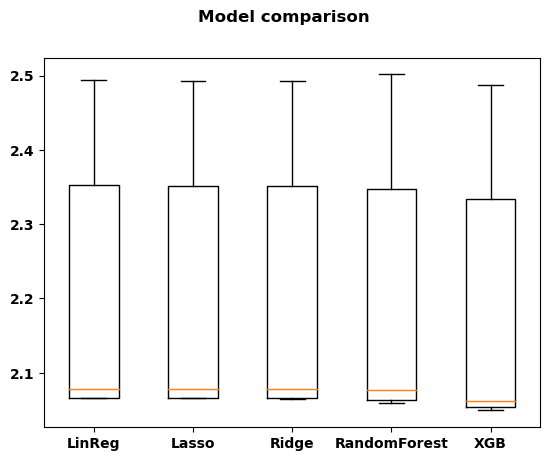

In [69]:
model_names, model_results = get_cv_scores(models, X_train, y_train)
compare_model_scores(model_names, model_results)